In [1]:
# General Packages
import pandas as pd
import numpy as np
import random as rnd
import os
import re
# import multiprocessing

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = (16, 8)
import scikitplot as skplt

# Supervised Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron, SGDClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import feature_selection
import xgboost as xgb
from xgboost.sklearn import XGBClassifier # <3

# Unsupervised Models
from sklearn.decomposition import PCA

# Evalaluation
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Grid
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st

# Pipeline
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import Pipeline

# Esemble Voting
from mlxtend.classifier import EnsembleVoteClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score

# Stacking
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from matplotlib.colors import ListedColormap

# Warnings
import warnings
warnings.filterwarnings('ignore')

import time
import datetime
import platform
start = time.time()

/home/tapas/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
print('Version      :', platform.python_version())
print('Compiler     :', platform.python_compiler())
print('Build        :', platform.python_build())

print("\nCurrent date and time using isoformat:")
print(datetime.datetime.now().isoformat())

Version      : 3.6.2
Compiler     : GCC 7.2.0
Build        : ('default', 'Sep 30 2017 18:42:57')

Current date and time using isoformat:
2018-03-12T15:53:27.647986


In [3]:
# Master Parameters:
n_splits = 5 # Cross Validation Splits
n_iter = 65 # Randomized Search Iterations
scoring = 'accuracy' # Model Selection during Cross-Validation
rstate = 25 # Random State used 
testset_size = 0.30

# Trees Parameters
n_tree_range = st.randint(600, 1200)

# XGboost boosting rounds
num_rounds = 1000

In [4]:
import os
os.chdir('/home/tapas/Default_Prediction_Research-master/')
os.listdir(".")

['Keras_implementation.ipynb',
 'data.csv',
 'Ensembling_Voting_Classifier.ipynb',
 '.gitignore',
 '.ipynb_checkpoints',
 'Literatre of Model.ipynb',
 'Experiment_preprocessing.ipynb',
 'Voting_Pipeline_Stack_without_PCA.ipynb',
 'Experiment_with_Feature_selection.ipynb']

In [64]:
# Load
df = pd.read_csv('data.csv')
df = df.sample(frac=1).reset_index(drop= True)
Target = df['Target'].copy()
traindex = df.index

In [67]:
df.isnull().sum()

Company.Name    0
PBDITAM         0
PATMARG         0
CASHPRFM        0
NPM             0
ROE             0
ROCE            0
RONW            0
TNW             0
CR              0
QR              0
DE              0
EXP%SALES       0
FOREXEARNGS     0
DR              0
CL/NW           0
SALES           0
Size            0
MKTCAP          0
LTD             0
DEBTORDAYS      0
CREDITORDAYS    0
NWCCYCLE        0
YEAR            0
Target          0
dtype: int64

In [68]:
df.columns

Index(['Company.Name', 'PBDITAM', 'PATMARG', 'CASHPRFM', 'NPM', 'ROE', 'ROCE',
       'RONW', 'TNW', 'CR', 'QR', 'DE', 'EXP%SALES', 'FOREXEARNGS', 'DR',
       'CL/NW', 'SALES', 'Size', 'MKTCAP', 'LTD', 'DEBTORDAYS', 'CREDITORDAYS',
       'NWCCYCLE', 'YEAR', 'Target'],
      dtype='object')

In [69]:
del df['Company.Name']

### Feature Engineering

In [70]:
df['YEAR'] = df['YEAR'].astype('category')

In [71]:
age_bins = [0,1960,1970,1980,1990,2000,2017]
age_labels = ['1','2','3','4','5','6']
df['YEAR'] = pd.cut(df['YEAR'], age_bins, labels = age_labels,right=True,include_lowest = True)

In [72]:
df['Age_1'] = df['YEAR'].map(lambda s:1 if s == '1' else 0)
df['Age_2'] = df['YEAR'].map(lambda s:1 if s == '2' else 0)
df['Age_3'] = df['YEAR'].map(lambda s:1 if s == '3' else 0)
df['Age_4'] = df['YEAR'].map(lambda s:1 if s == '4' else 0)
df['Age_5'] = df['YEAR'].map(lambda s:1 if s == '5' else 0)
df['Age_6'] = df['YEAR'].map(lambda s:1 if s == '6' else 0)
#del df['YEAR']
df = df.drop(labels = ['YEAR'],axis = 1)

In [73]:
# Depedent and Indepedent Variables
X = df.drop(["Target"] , axis=1)
y = df["Target"]
print("X, Y:",X.shape, y.shape) # Data Dimensions

# Storage for Model and Results
results = pd.DataFrame(columns=['Model','Para','Test_Score','CV Mean','CV STDEV'])
ensemble_models= {}

X, Y: (727, 28) (727,)


### Imbalanced Dependent Variable

In [74]:
print("Depedent Variable Distribution")
print(y.value_counts(normalize=True)*100)
print("0 = Insolvent", "\n1 = Solvent")

Depedent Variable Distribution
0    77.716644
1    22.283356
Name: Target, dtype: float64
0 = Insolvent 
1 = Solvent


### Dimensionality Reduction: Principal Components

In [75]:
print("Feature Count (With One Hot Encoding):", X.shape[1])

Feature Count (With One Hot Encoding): 28


In [76]:
levels = [2,4,6,8,10,12]
for x in levels:
    pca = PCA(n_components=x)
    fit = pca.fit(df)

    print(("{} Components \nExplained Variance: {}\n").format(x, fit.explained_variance_ratio_))
    #print(fit.components_)

2 Components 
Explained Variance: [0.55179462 0.28895481]

4 Components 
Explained Variance: [0.55179462 0.28895481 0.08699055 0.03756468]

6 Components 
Explained Variance: [0.55179462 0.28895481 0.08699055 0.03756468 0.01275761 0.0093668 ]

8 Components 
Explained Variance: [0.55179462 0.28895481 0.08699055 0.03756468 0.01275761 0.0093668
 0.00622672 0.00334337]

10 Components 
Explained Variance: [0.55179462 0.28895481 0.08699055 0.03756468 0.01275761 0.0093668
 0.00622672 0.00334337 0.00162333 0.0013562 ]

12 Components 
Explained Variance: [5.51794616e-01 2.88954810e-01 8.69905520e-02 3.75646808e-02
 1.27576148e-02 9.36680299e-03 6.22671955e-03 3.34337293e-03
 1.62333360e-03 1.35620179e-03 1.05516146e-05 1.02126834e-05]



In [77]:
"""
# Reduce Dimensionality
pca = PCA(n_components=5)
fit = pca.fit(X)

sns.heatmap(pd.concat([pd.DataFrame(fit.transform(X)), Target],
                      axis=1).corr(), annot=True, fmt=".2f")
# Apply Reduction
X = pd.DataFrame(fit.transform(X))
"""

'\n# Reduce Dimensionality\npca = PCA(n_components=5)\nfit = pca.fit(X)\n\nsns.heatmap(pd.concat([pd.DataFrame(fit.transform(X)), Target],\n                      axis=1).corr(), annot=True, fmt=".2f")\n# Apply Reduction\nX = pd.DataFrame(fit.transform(X))\n'

### Preprocessing

In [78]:
feat = ['PBDITAM', 'PATMARG', 'CASHPRFM', 'NPM', 'ROE', 'ROCE', 'RONW', 'TNW',
       'CR', 'QR', 'DE', 'EXP%SALES', 'FOREXEARNGS', 'DR', 'CL/NW', 'SALES',
       'Size', 'MKTCAP', 'LTD', 'DEBTORDAYS', 'CREDITORDAYS', 'NWCCYCLE']

In [79]:
from scipy.stats import skew 
skewness = X[feat].apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

CL/NW           26.897929
DE              25.675147
RONW            21.264135
DEBTORDAYS      16.404473
CR              11.173833
QR               8.752535
CREDITORDAYS     8.190105
DR               6.392423
FOREXEARNGS      6.282399
SALES            5.674403
ROCE             5.229700
MKTCAP           4.553735
TNW              3.657857
Size             3.455293
LTD              3.129523
EXP%SALES        1.657726
ROE             -8.829597
NWCCYCLE       -22.101821
NPM            -25.166775
PBDITAM        -25.398950
PATMARG        -25.749162
CASHPRFM       -26.416320
dtype: float64

In [80]:
import numpy as np
for i in feat:
    X[i] = np.log10(X[i] + np.sqrt(1 + np.square(X[i])))

In [81]:
from scipy.stats import skew 
skewness = X[feat].apply(lambda x: skew(x))
skewness.sort_values(ascending=False)

CREDITORDAYS    2.350206
DE              2.073440
QR              2.057200
CR              1.930040
ROCE            0.751639
DR              0.339916
EXP%SALES       0.020657
FOREXEARNGS    -0.044801
CL/NW          -0.263209
LTD            -0.358114
MKTCAP         -0.919690
NWCCYCLE       -1.215810
SALES          -1.647685
RONW           -1.979992
NPM            -2.042285
ROE            -2.122614
PATMARG        -2.209853
CASHPRFM       -2.729573
TNW            -3.067843
DEBTORDAYS     -3.813100
PBDITAM        -4.090739
Size           -4.683394
dtype: float64

### Train/Test Split

In [82]:
# Stratified Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=testset_size, stratify=y,random_state=rstate)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

# Stratified Cross-Validation
cv = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2, random_state=rstate)

### Helper Functions

In [83]:
# Compute, Print, and Save Model Evaluation
def save(model, modelname):
    """
    This funciton saves the cross-validated and test set evaluation value and standard deviation
    to the results dataframe, then it executes the model prediction on the submission set.
    Finally, it also outputs a confusion matrix of the test set.
    
    Arguments:
    model = The Sklearn Randomized/Grid SearchCV model.
    modelname = String of the model name for saving purposes.
    """
    global results
    # Once best model is found, establish more evaluation metrics.
    model.best_estimator_.fit(X_train, y_train)
    
    # submission = model.predict(test_df)
    # df = pd.DataFrame({'PassengerId':test_df.index,'Survived':submission})
    # path = ...
    # df.to_csv((os.path.join(path,("submissions/{}.csv".format(modelname)))),header=True,index=False)
    
    scores = cross_val_score(model.best_estimator_, X_train, y_train, cv=5,
                             scoring=scoring, verbose =0)
    CV_scores = scores.mean()
    STDev = scores.std()
    Test_scores = model.score(X_test, y_test)

    # CV and Save scores
    results = results.append({'Model': modelname,'Para': model.best_params_,'Test_Score': Test_scores,
                             'CV Mean':CV_scores, 'CV STDEV': STDev}, ignore_index=True)
    ensemble_models[modelname] = model.best_estimator_
    
    # Print Evaluation
    print("\nEvaluation Method: {}".format(scoring))
    print("Optimal Model Parameters: {}".format(grid.best_params_))
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (CV_scores, STDev, modelname))
    print('Test_Score:', Test_scores)
        
    # Scikit Confusion Matrix
    model.best_estimator_.fit(X_train, y_train)
    pred = model.predict(X_test)
    skplt.metrics.plot_confusion_matrix(y_test, pred, title="{} Confusion Matrix".format(modelname),
                normalize=True,figsize=(6,6),text_fontsize='large')
    plt.show()
    # Colors https://matplotlib.org/examples/color/colormaps_reference.html

def norm_save(model,score, modelname):
    global results
    model.fit(X, y)
    submission = model.predict(test_df)
    df = pd.DataFrame({'Company.Name':test_df.index, 
                           'Target':submission})
    
    CV_Score = score.mean()
    Test_scores = model.score(X_test, y_test)
    STDev = score.std()
    
    # CV and Save Scores
    Test_Score = model.score(X_test, y_test)
    results = results.append({'Model': modelname,'Para': model,'Test_Score': Test_scores,
                             'CV Mean': CV_Score, 'CV STDEV': STDev}, ignore_index=True)
    ensemble_models[modelname] = model
    
    print("\nEvaluation Method: {}".format(scoring))
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (CV_Score, STDev, modelname))  
    print('Test_Score:', Test_scores)
        
    #Scikit Confusion Matrix
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    skplt.metrics.plot_confusion_matrix(y_test, pred, title="{} Confusion Matrix".format(modelname),
                normalize=True,figsize=(6,6),text_fontsize='large')
    plt.show()
    
# ROC Curve Plot
# http://scikit-plot.readthedocs.io/en/stable/metrics.html
def eval_plot(model):
    skplt.metrics.plot_roc_curve(y_test, model.predict_proba(X_test))
    plt.show()

### K-Nearest Neighbors

Fitting 5 folds for each of 65 candidates, totalling 325 fits


[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:   12.6s finished



Evaluation Method: accuracy
Optimal Model Parameters: {'n_neighbors': 1, 'weights': 'uniform'}
Train CV Accuracy: 0.97 (+/- 0.01) [KNN]
Test_Score: 0.954337899543379


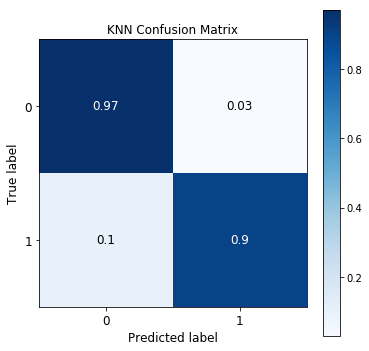

In [84]:
# Hyper parameters. Since RandomizedSearchCV is used, I use an uniform random interger range for the function to choose from.
param_grid ={'n_neighbors': st.randint(1,40),
             # Increasing this value reduces bias, and increases variance. Don't Overfit!
            'weights':['uniform','distance']
            }
# Hyper-Parameter Tuning with Cross-Validation
grid = RandomizedSearchCV(KNeighborsClassifier(),
                    param_grid, # Hyper Parameters
                    cv=cv, # Cross-Validation splits. Stratified.
                    scoring=scoring, # Best-Validation selection metric.
                    verbose=1, # Quality of Life. Frequency of model updates
                    n_iter=n_iter, # Number of hyperparameter combinations tried.
                    random_state=rstate) # Reproducibility 

# Execute Tuning on entire dataset
grid.fit(X_train, y_train)
save(grid, "KNN")

In [85]:
SGDClassifier().get_params().keys()

dict_keys(['alpha', 'average', 'class_weight', 'epsilon', 'eta0', 'fit_intercept', 'l1_ratio', 'learning_rate', 'loss', 'max_iter', 'n_iter', 'n_jobs', 'penalty', 'power_t', 'random_state', 'shuffle', 'tol', 'verbose', 'warm_start'])

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.5s finished



Evaluation Method: accuracy
Optimal Model Parameters: {'loss': 'hinge'}
Train CV Accuracy: 0.90 (+/- 0.07) [StochasticGradientDescent]
Test_Score: 0.9178082191780822


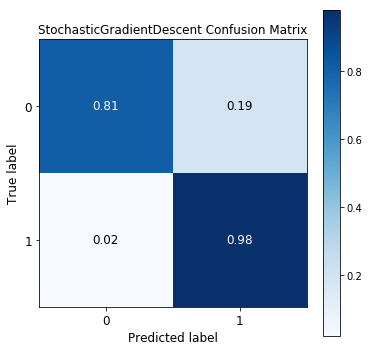

In [86]:
param_grid ={'loss':["hinge","log","modified_huber","epsilon_insensitive","squared_epsilon_insensitive"]
            }

grid = GridSearchCV(SGDClassifier(),
                    param_grid,cv=cv, scoring=scoring,
                    verbose=1)

grid.fit(X_train, y_train)
save(grid, "StochasticGradientDescent")

### Decision Trees

In [87]:
# Helper Function to visualize feature importance
predictors = [x for x in X.columns if x not in ['Target']]
def feature_imp(model):
    MO = model.fit(X_train, y_train)
    feat_imp = pd.Series(MO.feature_importances_, predictors).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [88]:
DecisionTreeClassifier().get_params().keys()

dict_keys(['class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'presort', 'random_state', 'splitter'])

### Feature Importance Graphic

Mean CV Accuracy: 0.9342465753424657


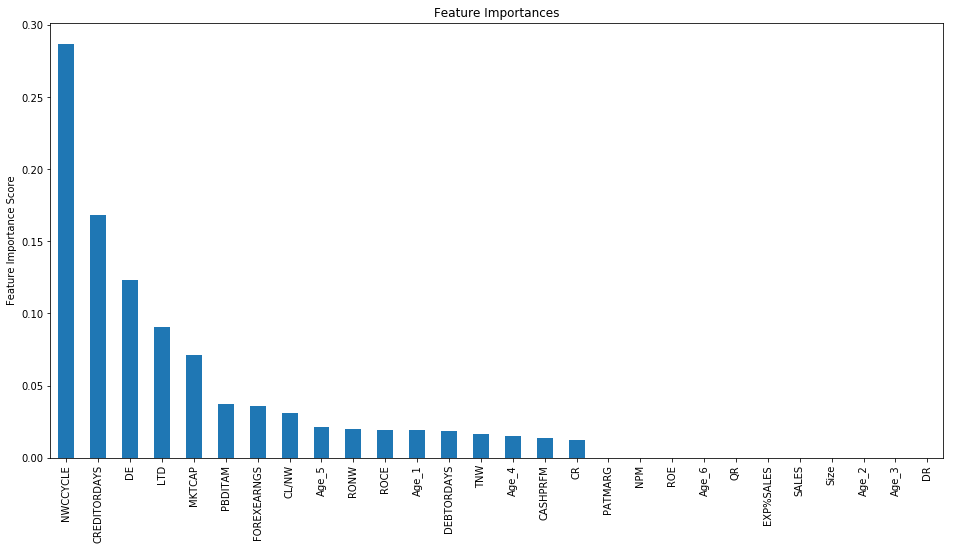

In [89]:
# Baseline Decision Tree
tree = DecisionTreeClassifier()
print("Mean CV Accuracy:",cross_val_score(tree, X, y, cv=cv, scoring=scoring).mean())
feature_imp(tree)

### Bootstrap aggregating (AKA Bagging) Decision Trees

Fitting 5 folds for each of 65 candidates, totalling 325 fits


[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed: 41.9min finished



Evaluation Method: accuracy
Optimal Model Parameters: {'n_estimators': 732}
Train CV Accuracy: 0.96 (+/- 0.02) [Bagger_ensemble]
Test_Score: 0.9726027397260274


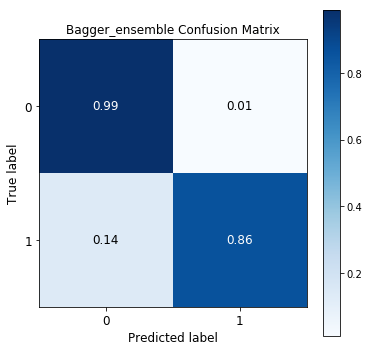

In [90]:
# Parameter Tuning
param_grid ={'n_estimators': n_tree_range}

tree = DecisionTreeClassifier()
grid = RandomizedSearchCV(BaggingClassifier(tree),
                    param_grid, cv=cv, scoring=scoring,
                    verbose=1,n_iter=n_iter, random_state=rstate)

grid.fit(X_train, y_train)
save(grid, "Bagger_ensemble")

### Random Forest

Mean CV Accuracy: 0.9739726027397261


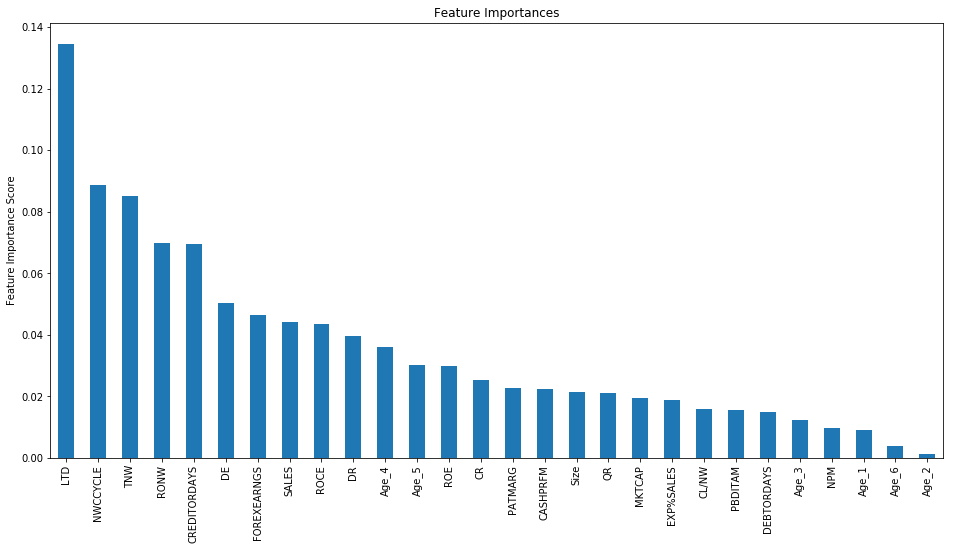

In [91]:
model = RandomForestClassifier()
print("Mean CV Accuracy:",cross_val_score(model, X, y, cv=cv, scoring=scoring).mean())
feature_imp(model)

In [92]:
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

Fitting 5 folds for each of 65 candidates, totalling 325 fits


[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed: 30.9min finished



Evaluation Method: accuracy
Optimal Model Parameters: {'max_depth': 8, 'max_features': 0.7000000000000002, 'max_leaf_nodes': 9, 'n_estimators': 706}
Train CV Accuracy: 0.95 (+/- 0.02) [Random_Forest]
Test_Score: 0.9497716894977168


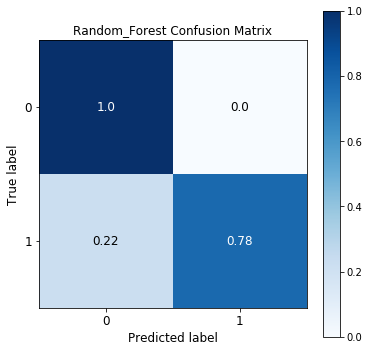

In [93]:
param_grid ={'max_depth': st.randint(6, 11),
             'n_estimators': n_tree_range,
             'max_features':np.arange(0.5,.81, 0.05),
            'max_leaf_nodes':st.randint(6, 10)}

model= RandomForestClassifier()

grid = RandomizedSearchCV(model,
                    param_grid, cv=cv,
                    scoring=scoring,
                    verbose=1,n_iter=n_iter, random_state=rstate)

grid.fit(X_train, y_train)
save(grid, "Random_Forest")

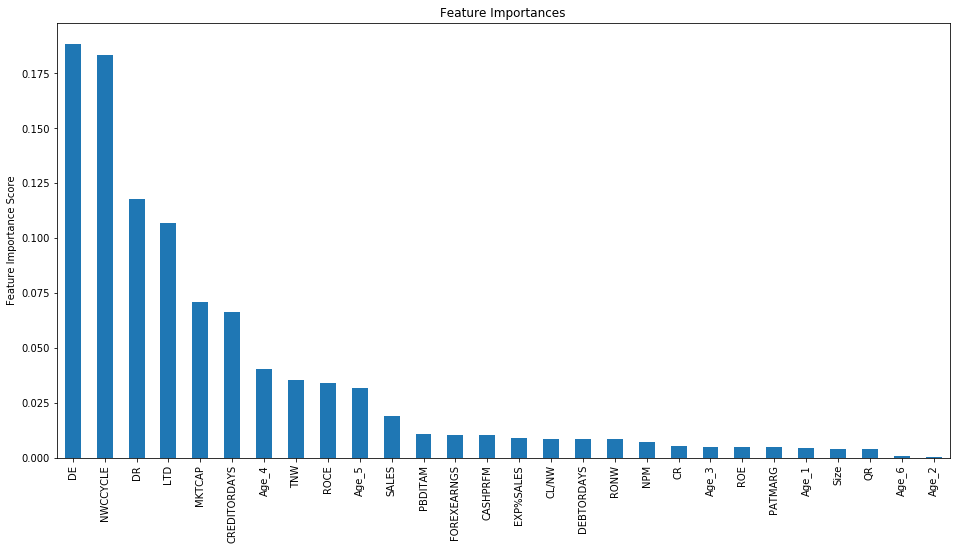

In [94]:
feature_imp(grid.best_estimator_)

### Adaptive Boosting

In [95]:
AdaBoostClassifier().get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

Fitting 5 folds for each of 65 candidates, totalling 325 fits


[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed: 24.9min finished



Evaluation Method: accuracy
Optimal Model Parameters: {'learning_rate': 1.6, 'n_estimators': 829}
Train CV Accuracy: 0.98 (+/- 0.01) [AdaBoost_Ensemble]
Test_Score: 0.9771689497716894


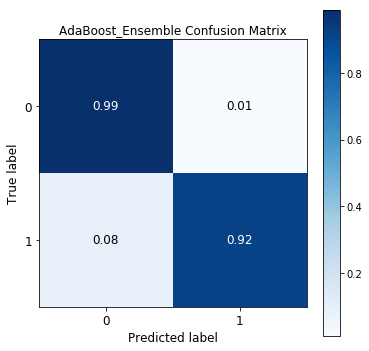

In [96]:
param_grid ={'n_estimators':n_tree_range,
            'learning_rate':np.arange(.1, 4, .5)}

grid = RandomizedSearchCV(AdaBoostClassifier(),
                    param_grid,cv=cv, scoring=scoring,
                    verbose=1, n_iter=n_iter, random_state=rstate)

grid.fit(X_train, y_train)
save(grid, "AdaBoost_Ensemble")

### Gradient Boosting Classifier

In [97]:
GradientBoostingClassifier().get_params().keys()

dict_keys(['criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'presort', 'random_state', 'subsample', 'verbose', 'warm_start'])

Fitting 5 folds for each of 65 candidates, totalling 325 fits


[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:  7.5min finished



Evaluation Method: accuracy
Optimal Model Parameters: {'learning_rate': 0.11, 'loss': 'exponential', 'max_depth': 4.0, 'n_estimators': 760}
Train CV Accuracy: 0.97 (+/- 0.01) [Gradient_Boosting]
Test_Score: 0.9817351598173516


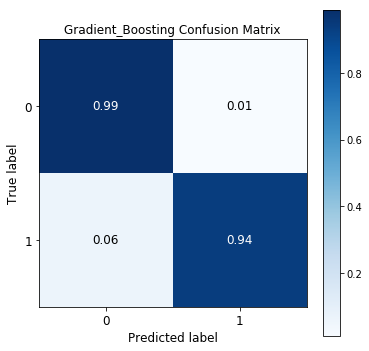

In [98]:
param_grid ={'n_estimators': n_tree_range,
            'loss': ['deviance', 'exponential'],
            'learning_rate':np.arange(0.01, 0.32,.05),
            'max_depth': np.arange(2, 4.1, .5)}

grid = RandomizedSearchCV(GradientBoostingClassifier(),
                    param_grid,cv=cv,
                    scoring=scoring,
                    verbose=1, n_iter=n_iter, random_state=rstate)

grid.fit(X_train, y_train)
save(grid, "Gradient_Boosting")

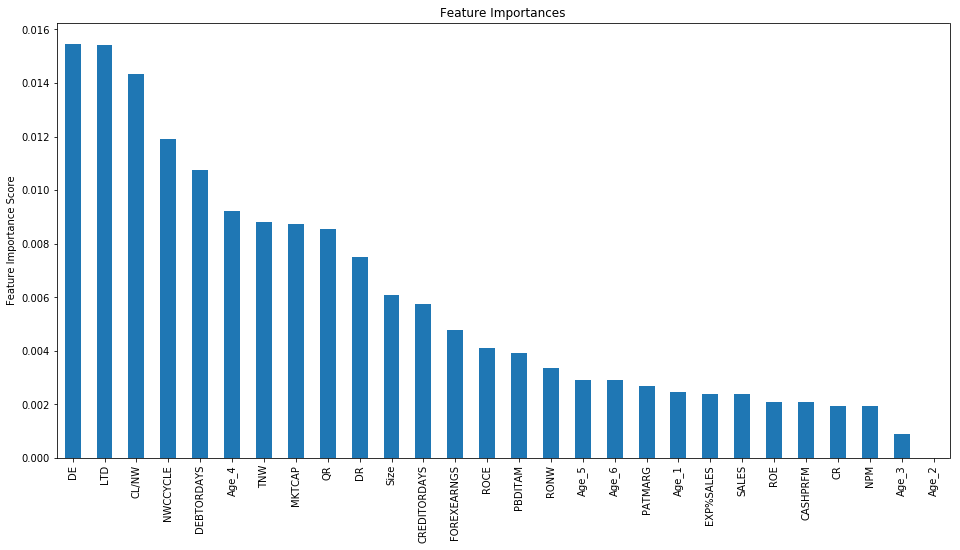

In [99]:
feature_imp(grid.best_estimator_)

### XGBoost - eXtreme Gradient Boosting

In [100]:
XGBClassifier().get_params().keys()

dict_keys(['base_score', 'colsample_bylevel', 'colsample_bytree', 'gamma', 'learning_rate', 'max_delta_step', 'max_depth', 'min_child_weight', 'missing', 'n_estimators', 'nthread', 'objective', 'reg_alpha', 'reg_lambda', 'scale_pos_weight', 'seed', 'silent', 'subsample'])

Fitting 3 folds for each of 65 candidates, totalling 195 fits


[Parallel(n_jobs=1)]: Done 195 out of 195 | elapsed:  1.8min finished



Evaluation Method: accuracy
Optimal Model Parameters: {'colsample_bytree': 0.9906366954227275, 'gamma': 0.7331385480730648, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 741, 'reg_alpha': 0, 'subsample': 0.9738491723577724}
Train CV Accuracy: 0.97 (+/- 0.01) [Sci_kit XGB]
Test_Score: 0.9863013698630136


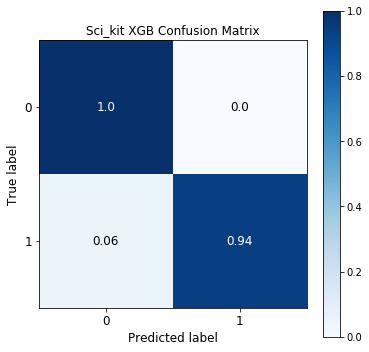

In [101]:
one_to_left = st.beta(10, 1)  
from_zero_positive = st.expon(0, 50)

params = {  
    "n_estimators": n_tree_range,
    "max_depth": st.randint(2, 8),
    "learning_rate": [0.01],
    #'max_features':'sqrt',
    #"learning_rate": st.uniform(0.001, 0.1),
    "colsample_bytree": one_to_left,
    "subsample": one_to_left,
    "gamma": st.uniform(0, 3),
    #'reg_alpha': from_zero_positive,
    #"min_child_weight": from_zero_positive,
    'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}

xgbreg = XGBClassifier(objective= 'binary:logistic')

grid = RandomizedSearchCV(xgbreg, params, n_jobs=1, verbose=1, n_iter=n_iter,
                          random_state=rstate, scoring=scoring)  
grid.fit(X_train,y_train, verbose=False)
save(grid, "Sci_kit XGB")

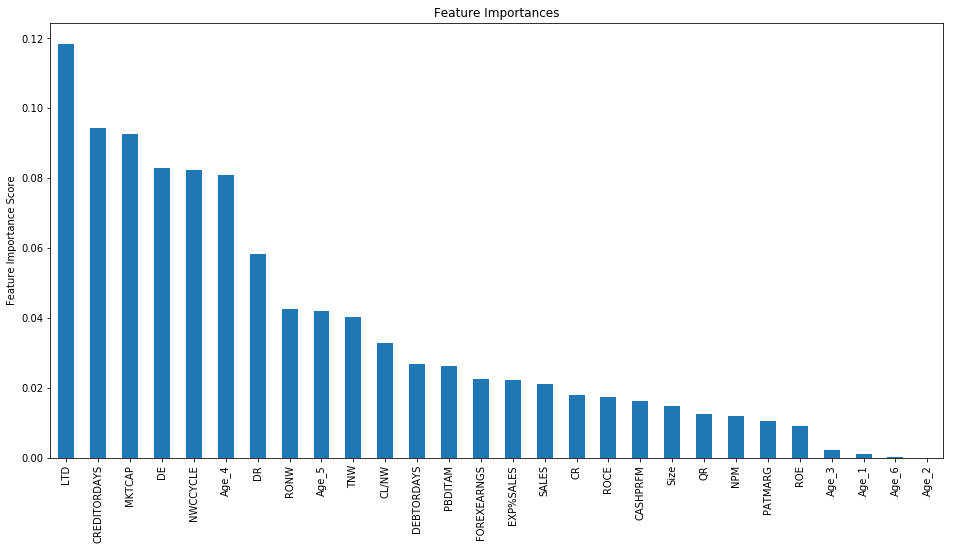

In [102]:
feature_imp(grid.best_estimator_)

In [103]:
model = XGBClassifier(n_estimators = num_rounds,
                        objective= 'binary:logistic',
                     learning_rate=0.01)

# use early_stopping_rounds to stop the cv when there is no score imporovement
model.fit(X_train,y_train, early_stopping_rounds=20, eval_set=[(X_test,
y_test)], verbose=False)
score = cross_val_score(model, X_train,y_train, cv=cv)
print(model)
print("\nxgBoost - CV Train : %.2f" % score.mean())
print("xgBoost - Train : %.2f" % metrics.accuracy_score(model.predict(X_train), y_train))
print("xgBoost - Test : %.2f" % metrics.accuracy_score(model.predict(X_test), y_test))
#norm_save(model,score, "XGBsklearn")

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.01, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=1000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

xgBoost - CV Train : 0.97
xgBoost - Train : 0.96
xgBoost - Test : 0.92


### XGBoost Package Implementation

In [104]:
xgtrain = xgb.DMatrix(X_train, label=y_train)
xgtest = xgb.DMatrix(X_test, label=y_test)

# set xgboost params
param = {'max_depth': 3,  # the maximum depth of each tree
         'objective': 'binary:logistic'}

clf_xgb_cv = xgb.cv(param, xgtrain, num_rounds, 
                    stratified=True, 
                    nfold=n_splits, 
                    early_stopping_rounds=20)
print("Optimal number of trees/estimators is %i" % clf_xgb_cv.shape[0])

watchlist  = [(xgtest,'test'), (xgtrain,'train')]                
clf_xgb = xgb.train(param, xgtrain,clf_xgb_cv.shape[0], watchlist)

# predict function will produce the probability 
# so we'll use 0.5 cutoff to convert probability to class label
y_train_pred = (clf_xgb.predict(xgtrain, ntree_limit=clf_xgb.best_iteration) > 0.5).astype(int)
y_test_pred = (clf_xgb.predict(xgtest, ntree_limit=clf_xgb.best_iteration) > 0.5).astype(int)
score= metrics.accuracy_score(y_test_pred, y_test)
print("\nXGB - CV Train : %.2f" % score)
print("XGB - Train : %.2f" % metrics.accuracy_score(y_train_pred, y_train))
#norm_save(model,score, "XGBstandard")

Optimal number of trees/estimators is 43
[0]	test-error:0.123288	train-error:0.086614
[1]	test-error:0.054795	train-error:0.035433
[2]	test-error:0.082192	train-error:0.041339
[3]	test-error:0.086758	train-error:0.03937
[4]	test-error:0.086758	train-error:0.035433
[5]	test-error:0.063927	train-error:0.029528
[6]	test-error:0.059361	train-error:0.021654
[7]	test-error:0.050228	train-error:0.015748
[8]	test-error:0.045662	train-error:0.01378
[9]	test-error:0.041096	train-error:0.009843
[10]	test-error:0.041096	train-error:0.011811
[11]	test-error:0.03653	train-error:0.011811
[12]	test-error:0.031963	train-error:0.009843
[13]	test-error:0.031963	train-error:0.005906
[14]	test-error:0.027397	train-error:0.003937
[15]	test-error:0.018265	train-error:0.003937
[16]	test-error:0.018265	train-error:0.003937
[17]	test-error:0.018265	train-error:0.003937
[18]	test-error:0.018265	train-error:0.001969
[19]	test-error:0.018265	train-error:0.001969
[20]	test-error:0.018265	train-error:0
[21]	test-err

### Logistic Regression

In [105]:
model= LogisticRegression()
score = cross_val_score(model, X_train, y_train, cv=cv, scoring='accuracy')
#norm_save(LogisticRegression(),score, "Logistic_Regression")

In [106]:
from scipy import stats
import statsmodels.api as sm

stats.chisqprob = lambda chisq, df: stats.chi2.sf(chisq, df)

logit = sm.Logit(y, X) # fit the model
result = logit.fit()
result.summary()

         Current function value: 0.037952
         Iterations: 35


/home/tapas/anaconda3/lib/python3.6/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 Target   No. Observations:                  727
Model:                          Logit   Df Residuals:                      699
Method:                           MLE   Df Model:                           27
Date:                Mon, 12 Mar 2018   Pseudo R-squ.:                  0.9285
Time:                        20:10:49   Log-Likelihood:                -27.591
converged:                      False   LL-Null:                       -385.65
                                        LLR p-value:                1.595e-133
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
PBDITAM         -0.8572      2.281     -0.376      0.707      -5.327       3.613
PATMARG         25.5762      8.972      2.851      0.004       7.992      43.161
CASHPRFM       -16.6263      4.480     -3.712      0.000     -25.406      -7.846
NPM            -10.8082      4.950     -2.183      0.029     -20.510      -1.106
ROE            -19.8716      6.864     -2.895      0.004     -33.325      -6.418
ROCE             9.9337      3.584      2.772      0.006       2.910      16.958
RONW            16.7633      4.852      3.455      0.001       7.254      26.272
TNW              4.5434      1.406      3.232      0.001       1.789       7.298
CR               5.2430      6.400      0.819      0.413      -7.301      17.787
QR              -3.2792      6.381     -0.514      0.607     -15.786       9.228
DE              14.2568      3.696      3.858      0.000       7.013      21.500
EXP%SALES      -45.1198     18.129     -2.489      0.013     -80.653      -9.587
FOREXEARNGS     44.4467     18.161      2.447      0.014       8.852      80.042
DR              -2.2291      0.855     -2.608      0.009      -3.904      -0.554
CL/NW           -2.0166      0.821     -2.456      0.014      -3.626      -0.407
SALES           -6.5813      2.227     -2.955      0.003     -10.946      -2.217
Size             4.4182      1.913      2.310      0.021       0.670       8.167
MKTCAP          -3.3104      0.897     -3.689      0.000      -5.069      -1.552
LTD              1.9062      0.567      3.360      0.001       0.794       3.018
DEBTORDAYS      -0.5493      2.012     -0.273      0.785      -4.493       3.395
CREDITORDAYS     5.0054      1.792      2.794      0.005       1.494       8.517
NWCCYCLE         1.0389      0.363      2.865      0.004       0.328       1.750
Age_1          -29.9945     11.231     -2.671      0.008     -52.007      -7.982
Age_2          -39.6707   1551.776     -0.026      0.980   -3081.097    3001.755
Age_3          -21.0254      7.995     -2.630      0.009     -36.696      -5.355
Age_4          -15.3433      7.143     -2.148      0.032     -29.343      -1.343
Age_5         -126.8879   2.05e+10  -6.18e-09      1.000   -4.03e+10    4.03e+10
Age_6          -26.6561      8.633     -3.088      0.002     -43.577      -9.735
================================================================================

Possibly complete quasi-separation: A fraction 0.77 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

### Feedforward Neural Networks

In [107]:
MLPClassifier().get_params().keys()

dict_keys(['activation', 'alpha', 'batch_size', 'beta_1', 'beta_2', 'early_stopping', 'epsilon', 'hidden_layer_sizes', 'learning_rate', 'learning_rate_init', 'max_iter', 'momentum', 'nesterovs_momentum', 'power_t', 'random_state', 'shuffle', 'solver', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

Fitting 5 folds for each of 65 candidates, totalling 325 fits


[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:   41.3s finished



Evaluation Method: accuracy
Optimal Model Parameters: {'max_iter': 77, 'learning_rate': 'adaptive', 'hidden_layer_sizes': 1000, 'early_stopping': True, 'alpha': 1000, 'activation': 'tanh'}
Train CV Accuracy: 0.79 (+/- 0.04) [FFNeural_Net]
Test_Score: 0.7853881278538812


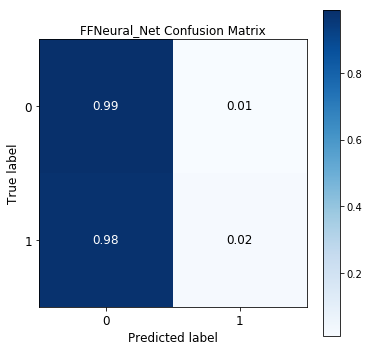

In [108]:
# Start with a RandomSearchCV to efficiently Narrow the Ballpark
param_grid ={'max_iter': np.logspace(1, 5, 10).astype("int32"),
             'hidden_layer_sizes': np.logspace(2, 3, 4).astype("int32"),
             'activation':['identity', 'logistic', 'tanh', 'relu'],
             'learning_rate': ['adaptive'],
             'early_stopping': [True],
             'alpha': np.logspace(2, 3, 4).astype("int32")
            }

model = MLPClassifier()
grid = RandomizedSearchCV(model,
                    param_grid, cv=cv, scoring=scoring,
                    verbose=1, n_iter=n_iter, random_state=rstate)

grid.fit(X_train, y_train)
save(grid, "FFNeural_Net")

In [109]:
grid.best_estimator_

MLPClassifier(activation='tanh', alpha=1000, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=True, epsilon=1e-08,
       hidden_layer_sizes=1000, learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=77, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

### Support Vector Classifier

In [110]:
LinearSVC().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'loss', 'max_iter', 'multi_class', 'penalty', 'random_state', 'tol', 'verbose'])

In [111]:
# Define Model
model = LinearSVC()

#Fit Model
scores= cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
#norm_save(model, scores, "LinearSV")

### Radial Basis Function (RBF)

In [112]:
SVC().get_params().keys()

dict_keys(['C', 'cache_size', 'class_weight', 'coef0', 'decision_function_shape', 'degree', 'gamma', 'kernel', 'max_iter', 'probability', 'random_state', 'shrinking', 'tol', 'verbose'])

Fitting 5 folds for each of 65 candidates, totalling 325 fits


[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:   34.0s finished



Evaluation Method: accuracy
Optimal Model Parameters: {'svc__C': 307, 'svc__gamma': 0.021544346900318846}
Train CV Accuracy: 0.98 (+/- 0.01) [SVCrbf]
Test_Score: 0.9634703196347032


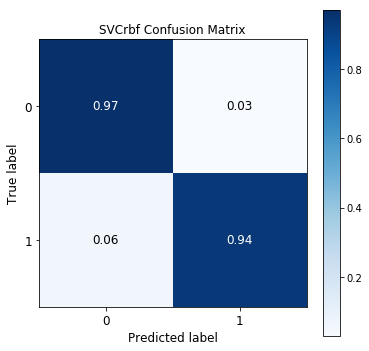

In [113]:
svc = SVC(kernel= 'rbf', probability=True)

model = Pipeline(steps=[('svc', svc)])


param_grid = {'svc__C': st.randint(1,10000),
              'svc__gamma': np.logspace(1, -7, 10)}

grid = RandomizedSearchCV(model, param_grid,
                          cv=cv, verbose=1, scoring=scoring,
                         n_iter=n_iter, random_state=rstate)

grid.fit(X_train, y_train)
save(grid, "SVCrbf")

### Pipeline and Principal Components Analysis and Support Vector Classifier

Fitting 5 folds for each of 65 candidates, totalling 325 fits


[Parallel(n_jobs=1)]: Done 325 out of 325 | elapsed:  1.1min finished



Evaluation Method: accuracy
Optimal Model Parameters: {'pca__n_components': 23, 'svc__C': 7683, 'svc__gamma': 0.0027825594022071257}
Train CV Accuracy: 0.97 (+/- 0.01) [PCA_SVC]
Test_Score: 0.954337899543379


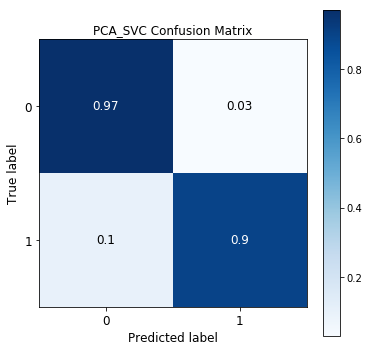

In [114]:
pca = PCA()
svc = SVC(kernel= 'rbf',probability=True)

model = Pipeline(steps=[('pca',pca),
                        ('svc', svc)])


param_grid = {'svc__C': st.randint(1,10000),
              'svc__gamma': np.logspace(1, -7, 10),
             'pca__n_components': st.randint(1,len(X.columns))}

grid = RandomizedSearchCV(model, param_grid,
                          cv=cv, verbose=1,
                         n_iter=n_iter, random_state=rstate, scoring=scoring)

grid.fit(X_train, y_train)
save(grid, "PCA_SVC")

In [115]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):
    """Generate a simple plot of the test and training learning curve"""
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

# Parametric Generative Classification

### Gaussian Naive Bayes

In [116]:
model = GaussianNB()

score = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
#norm_save(model,score, "Gaussian")

In [117]:
results = results.sort_values(by=["CV Mean"], ascending=False)
results

,Model,Para,Test_Score,CV Mean,CV STDEV
8,SVCrbf,"{'svc__C': 307, 'svc__gamma': 0.02154434690031...",0.963470,0.984275,0.007863
4,AdaBoost_Ensemble,"{'learning_rate': 1.6, 'n_estimators': 829}",0.977169,0.978334,0.013036
5,Gradient_Boosting,"{'learning_rate': 0.11, 'loss': 'exponential',...",0.981735,0.974413,0.009999
6,Sci_kit XGB,"{'colsample_bytree': 0.9906366954227275, 'gamm...",0.986301,0.970491,0.008726
9,PCA_SVC,"{'pca__n_components': 23, 'svc__C': 7683, 'svc...",0.954338,0.970491,0.010776
0,KNN,"{'n_neighbors': 1, 'weights': 'uniform'}",0.954338,0.966511,0.014762
2,Bagger_ensemble,{'n_estimators': 732},0.972603,0.956688,0.020315
3,Random_Forest,"{'max_depth': 8, 'max_features': 0.70000000000...",0.949772,0.950806,0.016500
1,StochasticGradientDescent,{'loss': 'hinge'},0.917808,0.903669,0.066488
7,FFNeural_Net,"{'max_iter': 77, 'learning_rate': 'adaptive', ...",0.785388,0.789303,0.042227


# Classification Voting: Model Ensemble

In [118]:
### Ensemble Voting
not_proba_list = ('LinearSV','StochasticGradientDescent')
not_proba =  results.query("Model in @not_proba_list")
hard_models = results # All Can Be
prob_models = results.query("Model not in @not_proba_list") # Not All
# [x for x in results.Model if x not in not_proba_list]

# Submission DataFrame for correlation purposes
# Hard Output
test_hard_pred_matrix = pd.DataFrame()
train_hard_pred_matrix = pd.DataFrame()

#Soft Output
test_soft_pred_matrix = pd.DataFrame()
train_soft_pred_matrix = pd.DataFrame()

In [119]:
# None Probabilistic
models = list(zip([ensemble_models[x] for x in not_proba.Model],
                  not_proba.Model))
clfs = []
print('5-fold cross validation:\n')
for clf, label in models:
    scores = cross_val_score(clf, X_train, y_train, cv=cv, scoring=scoring, verbose=0)
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    md = clf.fit(X_train, y_train)    
    clfs.append(md)
    print("Test Accuracy: %0.2f \n" % (metrics.accuracy_score(clf.predict(X_test), y_test)))
    
    # Model on Full Data
    md = clf.fit(X,y)
    #submission = md.predict(test_df)
    #df = pd.DataFrame({'Company.Name':test_df.index, 
    #                     'Target':submission})
    train_hard_pred_matrix = pd.concat((train_hard_pred_matrix, pd.DataFrame({label: md.predict(X)})), axis=1)
    #test_hard_pred_matrix = pd.concat((test_hard_pred_matrix, pd.DataFrame({label: submission})), axis=1)
    df.to_csv("{}.csv".format(label),header=True,index=False)

del clfs

5-fold cross validation:

Train CV Accuracy: 0.90 (+/- 0.04) [StochasticGradientDescent]
Test Accuracy: 0.82 



5-fold cross validation:

Train CV Accuracy: 0.98 (+/- 0.01) [SVCrbf]
ROC AUC: 1.00
Test Accuracy: 0.96 

Train CV Accuracy: 0.98 (+/- 0.01) [AdaBoost_Ensemble]
ROC AUC: 1.00
Test Accuracy: 0.98 

Train CV Accuracy: 0.98 (+/- 0.01) [Gradient_Boosting]
ROC AUC: 1.00
Test Accuracy: 0.98 

Train CV Accuracy: 0.97 (+/- 0.01) [Sci_kit XGB]
ROC AUC: 1.00
Test Accuracy: 0.99 

Train CV Accuracy: 0.97 (+/- 0.01) [PCA_SVC]
ROC AUC: 0.99
Test Accuracy: 0.95 

Train CV Accuracy: 0.97 (+/- 0.01) [KNN]
ROC AUC: 0.93
Test Accuracy: 0.95 

Train CV Accuracy: 0.95 (+/- 0.02) [Bagger_ensemble]
ROC AUC: 0.99
Test Accuracy: 0.97 

Train CV Accuracy: 0.95 (+/- 0.02) [Random_Forest]
ROC AUC: 0.98
Test Accuracy: 0.95 

Train CV Accuracy: 0.78 (+/- 0.01) [FFNeural_Net]
ROC AUC: 0.62
Test Accuracy: 0.80 



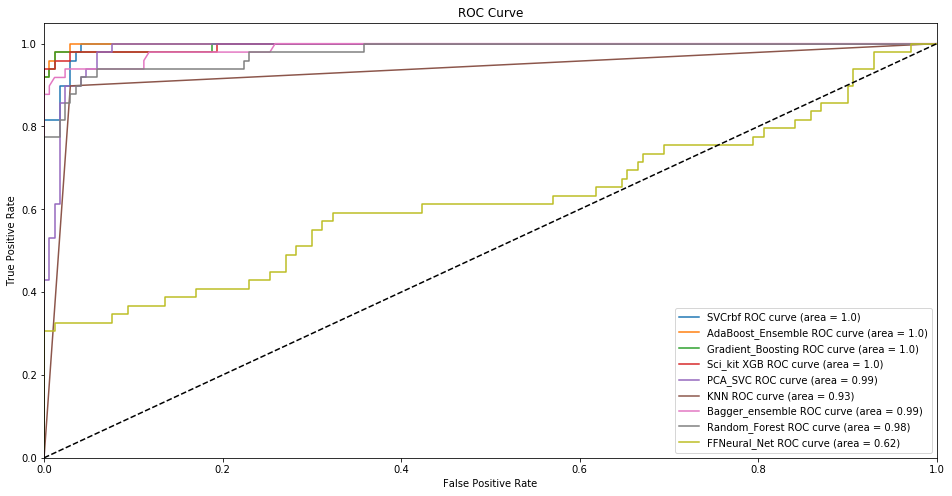

In [120]:
# Only Probabilistic
models = list(zip([ensemble_models[x] for x in prob_models.Model],
                  prob_models.Model))
plt.figure()

print('5-fold cross validation:\n')
clfs = []
#[ensemble_models[x] for x in prob_models.Model]
for clf, label in models:
    scores = cross_val_score(clf, X_train, y_train,cv=5, scoring=scoring, verbose=0)
    print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
    md = clf.fit(X_train, y_train)
    # Add to Roc Curve
    fpr, tpr, _ = roc_curve(y_test, md.predict_proba(X_test)[:,1])
    roc_auc = auc(fpr, tpr)

    print('ROC AUC: %0.2f' % roc_auc)
    plt.plot(fpr, tpr, label='{} ROC curve (area = {:.2})'.format(label, roc_auc))
    
    clfs.append(md)
    print("Test Accuracy: %0.2f \n" % (metrics.accuracy_score(clf.predict(X_test), y_test)))
    
    # Model on Full Data
    md = clf.fit(X,y)
    #submission = md.predict(test_df)
    #df = pd.DataFrame({'Comapny.Name':test_df.index, 
    #                       'Target':submission})
    train_hard_pred_matrix = pd.concat((train_hard_pred_matrix, pd.DataFrame({label: md.predict(X)})), axis=1)
    #test_hard_pred_matrix = pd.concat((test_hard_pred_matrix, pd.DataFrame({label: submission})), axis=1)

    train_soft_pred_matrix = pd.concat((train_soft_pred_matrix, pd.DataFrame({label: md.predict(X)})), axis=1)
    #test_soft_pred_matrix = pd.concat((test_soft_pred_matrix, pd.DataFrame({label: md.predict_proba(test_df)[:,1]})), axis=1)
    df.to_csv("{}.csv".format(label),header=True,index=False)

# Plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Receiver Operating Characteristic curve [ROC]


2-Voting Models: 5-fold cross validation:

Train CV Accuracy: 0.98 (+/- 0.01) [2-VM-Ensemble Soft Voting]
ROC AUC: 1.00
Train CV Accuracy: 0.98 (+/- 0.01) [2-VM-Ensemble Hard Voting]

3-Voting Models: 5-fold cross validation:

Train CV Accuracy: 0.98 (+/- 0.01) [3-VM-Ensemble Soft Voting]
ROC AUC: 1.00
Train CV Accuracy: 0.99 (+/- 0.01) [3-VM-Ensemble Hard Voting]

5-Voting Models: 5-fold cross validation:

Train CV Accuracy: 0.98 (+/- 0.01) [5-VM-Ensemble Soft Voting]
ROC AUC: 1.00
Train CV Accuracy: 0.98 (+/- 0.01) [5-VM-Ensemble Hard Voting]

7-Voting Models: 5-fold cross validation:

Train CV Accuracy: 0.98 (+/- 0.02) [7-VM-Ensemble Soft Voting]
ROC AUC: 1.00
Train CV Accuracy: 0.98 (+/- 0.01) [7-VM-Ensemble Hard Voting]

10-Voting Models: 5-fold cross validation:

Train CV Accuracy: 0.98 (+/- 0.01) [10-VM-Ensemble Soft Voting]
ROC AUC: 1.00
Train CV Accuracy: 0.97 (+/- 0.01) [10-VM-Ensemble Hard Voting]


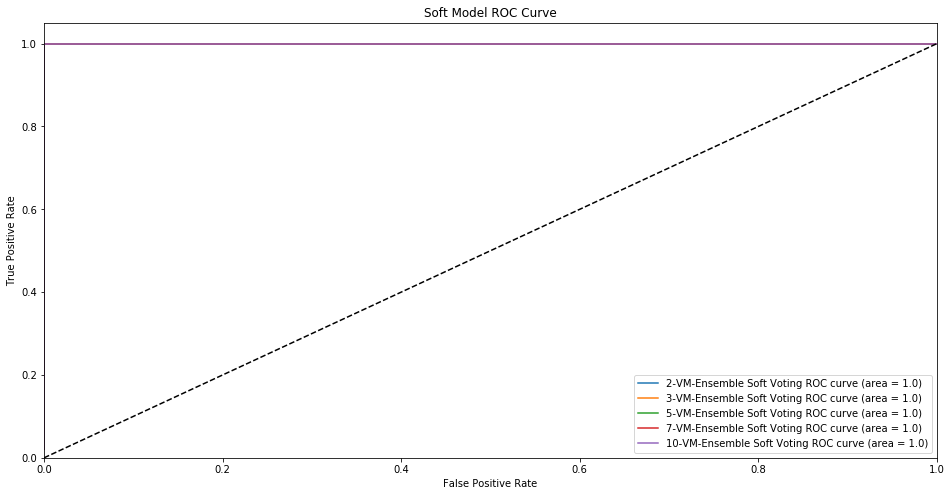

In [121]:
# Play with Weights
plt.figure()
voters = {}
for x in [2,3,5,7,10]:
    ECH = EnsembleVoteClassifier([ensemble_models.get(key) for key in hard_models.Model[:x]], voting='hard')
    ECS = EnsembleVoteClassifier([ensemble_models.get(key) for key in prob_models.Model[:x]], voting='soft')
    print('\n{}-Voting Models: 5-fold cross validation:\n'.format(x))
    
    for clf, label in zip([ECS, ECH], 
                          ['{}-VM-Ensemble Soft Voting'.format(x),
                           '{}-VM-Ensemble Hard Voting'.format(x)]):
        scores = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
        print("Train CV Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))
        md = clf.fit(X_train, y_train)    
        clfs.append(md)        
        
        #Test_Score = metrics.accuracy_score(clf.predict(X_test), y_test)
        #print("Test Accuracy: %0.2f " % Test_Score)
        
        CV_Score = scores.mean()
        STDev = scores.std()
        
        global results
        results = results.append({'Model': label,'Para': clf, 'CV Mean': CV_Score,
                                  'CV STDEV': STDev}, ignore_index=True)
        voters[label] = clf
        
        # Model on Full Data
        md = clf.fit(X,y)
        #submission = md.predict(test_df)
        #df = pd.DataFrame({'Company.name':test_df.index,'Target':submission})
        df.to_csv("{}.csv".format(label),header=True,index=False)
        
        if clf is ECH:
            # Hard Correlation
            train_hard_pred_matrix = pd.concat((train_hard_pred_matrix, pd.DataFrame({label: md.predict(X)})), axis=1)
            #test_hard_pred_matrix = pd.concat((test_hard_pred_matrix, pd.DataFrame({label: submission})), axis=1)
        
        elif clf is ECS:
            # Add to Roc Curve
            fpr, tpr, _ = roc_curve(y_test, md.predict_proba(X_test)[:,1])
            roc_auc = auc(fpr, tpr)
            print('ROC AUC: %0.2f' % roc_auc)
            plt.plot(fpr, tpr, label='{} ROC curve (area = {:.2})'.format(label, roc_auc))
            # Soft Correlation
            train_soft_pred_matrix = pd.concat((train_soft_pred_matrix, pd.DataFrame({label: md.predict(X)})), axis=1)
            #test_soft_pred_matrix = pd.concat((test_soft_pred_matrix, pd.DataFrame({label: md.predict_proba(test_df)[:,1]})), axis=1)
        
        
# Plot
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Soft Model ROC Curve')
plt.legend(loc="lower right")
plt.show()

### Sklearn Voter Pipeline

In [122]:
voters.get('10-VM-Ensemble Hard Voting')

EnsembleVoteClassifier(clfs=[Pipeline(memory=None,
     steps=[('svc', SVC(C=307, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.021544346900318846,
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False))]), AdaBoostCl...e=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)],
            refit=True, verbose=0, voting='hard', weights=None)

In [123]:
Xstack = X.copy()
ystack = y.copy()
X_trainstack = X_train.copy()
X_teststack = X_test.copy()
y_trainstack = y_train.copy()
y_teststack = y_test.copy()

In [124]:
from sklearn import cross_validation
kfold = cross_validation.StratifiedKFold(y=y_trainstack, n_folds=5, random_state=rstate)
num_trees = 10
verbose = True # to print the progress

clfs = [ensemble_models.get('KNN'),
        ensemble_models.get('XGBstandard')]

# Creating train and test sets for blending
dataset_blend_train = np.zeros((X_trainstack.shape[0], len(clfs)))
dataset_blend_test = np.zeros((X_teststack.shape[0], len(clfs)))
#dataset_blend_test_df = np.zeros((test_df.shape[0], len(clfs)))

print('5-fold cross validation:')
for i, clf in enumerate(clfs):   
    scores = cross_validation.cross_val_score(clf, X_trainstack, y_trainstack, cv=kfold, scoring='accuracy')
    print("##### Base Model %0.0f #####" % i)
    print("Train CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
    clf.fit(X_trainstack, y_trainstack)   
    print("Train Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(X_trainstack), y_trainstack)))
    dataset_blend_train[:,i] = clf.predict_proba(X_trainstack)[:, 1]
    dataset_blend_test[:,i] = clf.predict_proba(X_teststack)[:, 1]
    #dataset_blend_test_df[:,i] = clf.predict_proba(test_df)[:, 1]
    print("Test Accuracy: %0.2f \n" % (metrics.accuracy_score(clf.predict(X_teststack), y_teststack)))    

print("##### Meta Model #####")
clf = LogisticRegression()
scores = cross_validation.cross_val_score(clf, dataset_blend_train, y_trainstack, cv=kfold, scoring=scoring)
clf.fit(dataset_blend_train, y_trainstack)
print("Train CV Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std()))
print("Train Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(dataset_blend_train), y_trainstack)))
print("Test Accuracy: %0.2f " % (metrics.accuracy_score(clf.predict(dataset_blend_test), y_teststack)))

# Correlate Results
#test_hard_pred_matrix = pd.concat((test_hard_pred_matrix, pd.DataFrame({label: clf.predict(dataset_blend_test_df)})), axis=1)
#train_hard_pred_matrix = pd.concat((train_hard_pred_matrix, pd.DataFrame({label: model.predict(dataset_blend_train)})), axis=1)

# Save
#pd.DataFrame({'Company.Name':test_df.index, 
    #'Target':clf.predict(dataset_blend_test_df)}).to_csv(
    #"{}.csv".format("Stacked"),header=True,index=False)

5-fold cross validation:
##### Base Model 0 #####
Train CV Accuracy: 0.97 (+/- 0.01)
Train Accuracy: 1.00 
Test Accuracy: 0.95 



TypeError: estimator should be an estimator implementing 'fit' method, None was passed

In [ ]:
score = cross_val_score(clf, X, y, cv=cv, scoring=scoring)
norm_save(clf, score, "stacked")
eval_plot(clf)

### Table of Results

In [ ]:
results.sort_values(by=["CV Mean"], ascending=False, inplace=True)
results.to_csv("results.csv", index=False)
results

# Classification Evaluation

In [62]:
# Reinstate Data, since it was meddled with during Stacked Models
X = train_df.drop(["Target"] , axis=1)
y = train_df["Target"]

# Stratified Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

evalmodel = EnsembleVoteClassifier([ensemble_models.get(key) for key in prob_models.Model[:7]], voting='soft')
evalmodel.fit(X_train, y_train)
y_pred = evalmodel.predict(X_test)
# Report
print("\n Report:")
print(classification_report(y_test, y_pred))
confusion_matrix(y_test, y_pred)
# Matrix
print("\n Matrix:")
skplt.metrics.plot_confusion_matrix(y_pred, y_test, normalize=True)
plt.show()

NameError: name 'train_df' is not defined

In [ ]:
import time
end = time.time()
print("Notebook took %0.2f minutes to Run"%((end - start)/60))